![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [1]:
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

def initial_system():
    qb = QuantBook()

    volatility_etfs = ["SQQQ", "TQQQ", "TVIX", "VIXY", "SPLV",
                   "UVXY", "EEMV", "EFAV", "USMV","SPY"]
    # Add Equity ------------------------------------------------
    for i in range(len(volatility_etfs)):
        qb.AddEquity(volatility_etfs[i],Resolution.Daily)
    history = qb.History(qb.Securities.Keys, 252*15,Resolution.Daily)
    history_SPY = history.loc['SPY']

    rsv = (history_SPY['close']-history_SPY['close'].rolling(9,min_periods = 1).min()) /((history_SPY['close'].rolling(9,min_periods = 1).max()-history_SPY['close'].rolling(9,min_periods = 1).min()))
    rsv = rsv.fillna(value = 0)
    rsv = rsv*100

    K = pd.DataFrame(np.zeros((len(rsv.index),1)),index = rsv.index)
    K.iloc[0] = rsv.iloc[0]+50
    # K = K.shift()*(2/3)+rsv*(1/3)

    D = pd.DataFrame(np.zeros((len(rsv.index),1)),index = rsv.index)
    D.iloc[0]=50

    for i in range(len(K.index)-1):
        K.iloc[i+1] = K.iloc[i]*(2/3)+rsv.iloc[i+1]*(1/3)


    for i in range(len(K.index)-1):
        D.iloc[i+1] = D.iloc[i]*(2/3)+K.iloc[i+1]*(1/3)

    #建立SPY KD值表格
    spy_kd = pd.concat([history_SPY['close'],rsv,K,D],axis = 1)
    spy_kd.columns = ['close','rsv','k','D']

    return [spy_kd,len(spy_kd.index),spy_kd.index[-1]]

In [2]:
def train_model(system):
    from sklearn import linear_model
    from datetime import datetime
    spy_kd = system[0]
    regr = linear_model.LinearRegression()
    spy_kd['ID'] = pd.DataFrame(spy_kd.index.indexer_at_time('2019-01-01'),index = spy_kd.index)
    time_T = datetime.isoformat(datetime.now()-timedelta(days=365))[:10]
    time_H = datetime.isoformat(datetime.now()-timedelta(days=365*5))[:10]
    cut_ID_H = int(spy_kd.loc[time_H:time_T].iloc[0].loc['ID'])
    cut_ID_T = int(spy_kd.loc[time_H:time_T].iloc[-1].loc['ID'])
    X = spy_kd.iloc[cut_ID_H:cut_ID_T][['ID','k']].values
    Y = spy_kd.iloc[cut_ID_H:cut_ID_T]['close'].values
########## start Train ###############3
    regr.fit(X,Y)
    Y_predict = regr.predict(spy_kd.iloc[cut_ID_T:][['ID','k']].values)
    connect_list = pd.concat([spy_kd.iloc[cut_ID_T:]['close'],pd.DataFrame(Y_predict,index = spy_kd.iloc[cut_ID_T:]['close'].index)],axis = 1)
    connect_list.columns = ['close','predict close']
    return np.array([regr.intercept_,regr.coef_[0],regr.coef_[1]]),connect_list

In [3]:
system = initial_system()
model = train_model(system)

In [4]:
model[0]

array([-103.48421397,    0.10405835,    0.10555487])

In [5]:
model[1]

,close,predict close
time,,
2018-10-20,270.808990,266.815480
2018-10-23,269.701006,267.102425
2018-10-24,268.210620,266.672198
2018-10-25,260.052719,265.867467
2018-10-26,264.876862,266.505298
2018-10-27,260.121355,265.841787
2018-10-30,258.660385,265.417919
2018-10-31,262.592258,266.283614
2018-11-01,265.416147,267.738455


In [6]:
def predict(time,K):
    from datetime import datetime
    time_ID = datetime.strptime(time, '%Y-%m-%d')-system[-1]
    return np.dot(np.array([1,time_ID.days+system[-2],K]),model[0])

In [13]:
x = predict('2019-10-22',90)

In [14]:
x

299.66847473748027

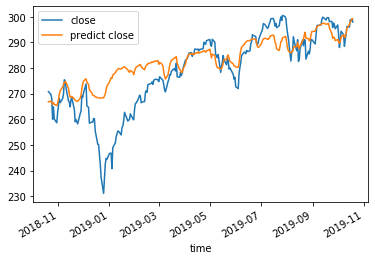

In [9]:
model[1].plot()